# 🧪 Notebook 5 — Model Evaluation & Tuning

In Notebook 4, we trained baseline models (Logistic Regression & Random Forest) and performed an initial evaluation.  

This was an exploratory check.

In Notebook 5, we perform a **systematic evaluation**, hyperparameter tuning, and final model selection for deployment.

---

Workflow Overview:

1. Load preprocessed data splits and saved models from Notebook 4.  
   
2. Evaluate baseline models on the validation set.  
   
3. Visualize confusion matrices.  
   
4. Perform hyperparameter tuning via GridSearchCV.
     
5. Plot **cross-validation ROC curves** to inspect model discrimination.  
   
6. Evaluate tuned models on the test set.  
   
7. Save best models for deployment.  
   
8. Compare baseline vs tuned vs test performance in a summary table.

---

## 5.1 Load Preprocessed Data & Models

We first need to:

- Load the **scaler** used for feature normalization (to ensure consistency).  

- Reload the **Logistic Regression** and **Random Forest** models saved in Notebook 4.  

📌 *Why?*  

We don’t want to retrain everything from scratch. By loading the models, we can continue the workflow where Notebook 4 left off.

In [12]:
import joblib

# Load scaler
scaler = joblib.load("models/scaler.pkl")

# Load models
log_reg = joblib.load("models/log_reg.pkl")
rf = joblib.load("models/random_forest.pkl")

# Load data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("models/splits.pkl")

# Scale the splits (using the same scaler fitted in Notebook 4)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("✅ Models, scaler, and splits loaded successfully")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

✅ Models, scaler, and splits loaded successfully
Train shape: (644, 16)
Validation shape: (138, 16)
Test shape: (138, 16)


---

## 5.2 Evaluate Baseline Models on Validation Set

We start by comparing both models on the **validation set**.  

Metrics we’ll use:

- **Accuracy** → Overall correctness  
  
- **Precision** → Of those predicted "disease", how many were correct?  
  
- **Recall (Sensitivity)** → Of actual disease cases, how many did we catch?  
  
- **F1-score** → Balance between precision & recall 
   
- **ROC-AUC** → Ability of the model to distinguish between positive/negative cases  

📌 *Why validation set?*  

We don’t want to test on the test set yet (to avoid bias). The validation set acts as a "practice test."

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

baseline_results = []

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}

for name, model in models.items():
    print(f"\n📊 {name} - Validation Set Performance")
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:,1]

    print(classification_report(y_val, y_val_pred, digits=3))
    roc_auc = roc_auc_score(y_val, y_val_proba)
    print("ROC-AUC:", roc_auc)
    
    baseline_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc
    })


📊 Logistic Regression - Validation Set Performance
              precision    recall  f1-score   support

           0      0.794     0.820     0.806        61
           1      0.853     0.831     0.842        77

    accuracy                          0.826       138
   macro avg      0.823     0.825     0.824       138
weighted avg      0.827     0.826     0.826       138

ROC-AUC: 0.9035554609325102

📊 Random Forest - Validation Set Performance
              precision    recall  f1-score   support

           0      0.605     0.852     0.707        61
           1      0.827     0.558     0.667        77

    accuracy                          0.688       138
   macro avg      0.716     0.705     0.687       138
weighted avg      0.729     0.688     0.685       138

ROC-AUC: 0.8565041515861189


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


---

## 5.3 Visualize Confusion Matrices

Confusion matrices show how predictions are distributed:

- **True Positives (TP):** correctly predicted disease  

- **True Negatives (TN):** correctly predicted no disease  
  
- **False Positives (FP):** predicted disease but actually healthy  
  
- **False Negatives (FN):** predicted healthy but actually disease  

📌 *Why this matters?*  

For medical predictions, **False Negatives are critical** — missing a real disease case is much worse than a false alarm.

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


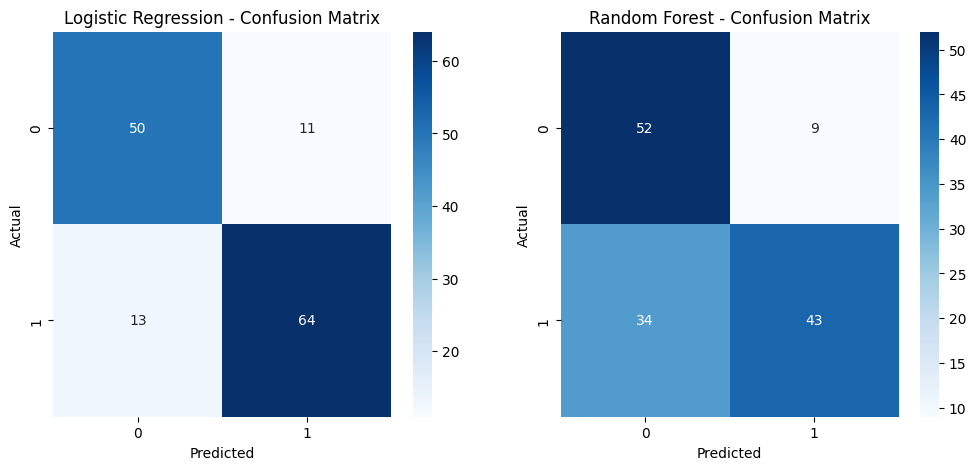

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_val, model.predict(X_val_scaled))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()

---

## 5.4 Hyperparameter Tuning

Now we try to **improve performance** by adjusting model hyperparameters.

- **Logistic Regression:**  
  
  - `C`: Regularization strength (smaller = stronger regularization).  
  
  - `solver`: Algorithm to optimize the model.  

- **Random Forest:**  
  
  - `n_estimators`: Number of trees in the forest.  
  
  - `max_depth`: Maximum depth of each tree.  
  
  - `min_samples_split`: Minimum samples required to split a node.  

📌 *Why tuning?*  

Default parameters may not be optimal. By searching systematically, we can reduce overfitting and increase generalization.

In [16]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_curve, auc
import numpy as np

# Logistic Regression tuning
log_reg_params = {"C": [0.01, 0.1, 1, 10], "solver": ["liblinear"]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_log = GridSearchCV(log_reg, log_reg_params, cv=cv, scoring="f1", return_train_score=True)
grid_log.fit(X_train_scaled, y_train)

# Random Forest tuning
rf_params = {"n_estimators": [100, 200],
             "max_depth": [None, 5, 10],
             "min_samples_split": [2, 5]}

grid_rf = GridSearchCV(rf, rf_params, cv=cv, scoring="f1", return_train_score=True)
grid_rf.fit(X_train_scaled, y_train)

print("Best Logistic Regression:", grid_log.best_params_)
print("Best Random Forest:", grid_rf.best_params_)

Best Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


---

---

---